##Progetto di Fondamenti di Scienza dei Dati e Laboratorio A.A.2025/2026
Sebastiano Assaloni
![Sebastiano Assaloni](BarbascuraTeflon.webp)




#Un'Analisi sulle Contee in West Virginia e Ohio
##Background
- I PFAS (sostanze per- e polifluoroalchiliche) sono composti chimici sintetici utilizzati in ambito industriale per la loro elevata stabilità chimica.
- Il PFOA è stato storicamente impiegato nella produzione del Teflon e di altri fluoropolimeri.
- Lo stabilimento DuPont(azienda inventrice del Teflon) Washington Works, situato a Parkersburg (West Virginia), ha operato lungo il fiume Ohio a partire dagli anni ’40, rilasciando PFOA nell’ambiente per diversi decenni.
- Questo studio si concentra sulle contee situate a valle dello stabilimento, storicamente esposte alla contaminazione lungo il corso del fiume.

##Obbiettivi e curiosità da cui è nato lo studio
- Verificare se le contee storicamente esposte alla contaminazione da PFAS lungo il fiume Ohio presentino tassi di incidenza del tumore renale più elevati rispetto ai valori di riferimento nazionali e statali.
- Di seguito tre link: il primo sulla correlazione PFAS-Cancro, il secondo sullo scandalo DuPont, il terzo rimanda al video di Barbascura
- https://www.airc.it/cancro/informazioni-tumori/corretta-informazione/i-pfas-possono-causare-il-cancro
- https://www.ewg.org/news-insights/news/why-are-dupont-and-chemours-still-discharging-most-notorious-forever-chemical
- https://www.youtube.com/watch?v=FpqzpRLxnkM&t=3s

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
PATH_DATA = os.path.join('data','raw') 

sns.set_theme(style="whitegrid",context="talk")

In [2]:
#lista che conterrà i Dataframe letti dai CSV
dfs=[] 
#Seleziono tutti i file CSV presenti nella cartella dei dati
lista_files = [file_name for file_name in os.listdir(PATH_DATA)  if 'csv' in file_name]
#print(lista_files)
for file_name in lista_files:
    #df temporaneo
    df = pd.read_csv(os.path.join(PATH_DATA, file_name))

    # Assegno la colonna 'State' in base al nome del file:
    # - file contenenti 'wv' → West Virginia
    # - file contenenti 'oh' → Ohio
    # - altrimenti → dataset nazionale (US)
    if "wv" in file_name.lower():
        df["state"] = "WV"
    elif "oh" in file_name.lower():
        df["state"] = "OH"
    else:
        df["state"] = "US"
    #Aggiungo il Dataframe alla lista dfs   
    dfs.append(df)
    
#Unisco tutti i DataFrame in un unico dataset
df = pd.concat(dfs, ignore_index=True) #evito indici duplicati

##Dataset utilizzati
- Dati di incidenza del tumore renale a livello di contea.
- Tasso di incidenza aggiustato per età (casi per 100.000 abitanti).
- Stati analizzati: West Virginia, Ohio e Stati Uniti (baseline nazionale).
- Periodo di riferimento coerente con i dati SEER/NPCR disponibili(2017-2021).

In [3]:
exposed_fips = [ #le contee esposte identificate dal loro ID univoco: FIPS
    54035,  # Jackson County, WV
    54053,  # Mason County, WV
    54087,  # Roane County, WV
    39105,  # Meigs County, OH
    39167   # Washington County, OH 
]

#elimino la linea di dati aggregati contenuta in tutti e 3 i file CSV
df = df[~df["County"].str.contains("US \\(SEER\\+NPCR\\)", regex=True, na=False)]
#rinomino le colonne
df = df.rename(columns={
    "FIPS": "Fips",
    "2023 Rural-Urban Continuum Codes([rural urban note])": "Rural/Urban",
    "Age-Adjusted Incidence Rate([rate note]) - cases per 100,000": "Age_Adjusted_Rate",
    "Average Annual Count": "Annual_Cases", "state": "State"
})
#trasformo Fips, AAR, Annual Cases da stringhe a numero
#valori non convertibili diventano NaN(coerce)
df["Fips"] = pd.to_numeric(df["Fips"], errors="coerce") 
df["Age_Adjusted_Rate"] = pd.to_numeric(df["Age_Adjusted_Rate"], errors="coerce") 
df["Annual_Cases"] = pd.to_numeric(df["Annual_Cases"], errors="coerce")

#creo la colonna exposed con valore 1 se FIPS è presente negli exposed FIPS e 0 altrimenti
df["Exposed"] = df["Fips"].isin(exposed_fips).astype(int)#converte il valore booleano 

#gestisco i dati mancanti o soppressi modificando il DF originale
df.replace("*", pd.NA, inplace=True)
df.replace("3 or fewer", pd.NA, inplace=True)


In [4]:
#creo dataframe US
df_US = df[df["State"] == "US"]

#creo dataframe per OHIO e WEST VIRGINIA
df_States = df[df["State"].isin(["WV", "OH"])].copy()

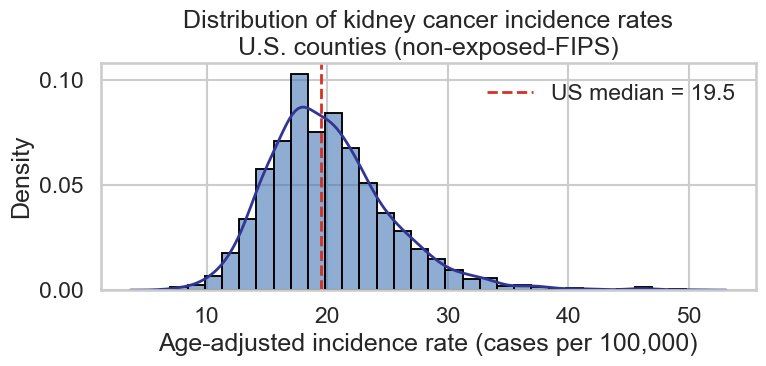

In [5]:
##National Baseline
"La mediana del US age-adjusted incidence rate è stata usata come baseline di riferimento"
#escludo exposed fips e valori non validi 
baseline = df_US[(~df_US["Fips"].isin(exposed_fips)) &
    (df_US["Age_Adjusted_Rate"].notna())]
#calcolo la mediana 
national_median = baseline["Age_Adjusted_Rate"].median()

#creo una colonna nel dataframe degli stati WV e OH indicando con 1 se il tasso d'incidenza > mediana, 0 altrimenti 
df_States["Above_US_Median"] = (
    df_States["Age_Adjusted_Rate"] > national_median
).astype(int)

df_Exposed = df_States[df_States["Exposed"] == 1]
#Imposto l'indice del dataframe sulla colonna del codice univoco FIPS
df_Exposed = df_Exposed.set_index("Fips")
#display(df_Exposed)
#national_median




#dimensione figura
plt.figure(figsize=(8,4))  


sns.histplot(
    baseline["Age_Adjusted_Rate"],
    bins=30,           #numero di bin
    stat="density",    #normalizza altezza istogramma in densità
    color="#4575b4",   #una sfumatura di colore blu chiaro
    alpha=0.6,         #trasparenza
    edgecolor="black"  #colore del bordo dei bin
)

#aggiungo una curva di densità stimata per visualizzare meglio distribuzione
sns.kdeplot(
    baseline["Age_Adjusted_Rate"],
    color="#313695", #sfumatura blu scuro
    linewidth=2
)

#linea verticale per indicare la mediana nazionale
plt.axvline(
    national_median,
    color="#d73027", #il rosso della linea
    linestyle="--",  #tipo di linea(tratteggiata)
    linewidth=2,
    label=f"US median = {national_median:.1f}" #etichetta linea con valore mediana
)

#etichette assi 
plt.xlabel("Age-adjusted incidence rate (cases per 100,000)")
plt.ylabel("Density")
#titolo grafico 
plt.title("Distribution of kidney cancer incidence rates\nU.S. counties (non-exposed-FIPS)")
#legenda senza frame
plt.legend(frameon=False)
#miglioro layouyt
plt.tight_layout()
plt.show()


##Baseline Nazionale
- La mediana del tasso di incidenza aggiustato per età del tumore renale nelle contee statunitensi è pari a 19.5 casi per 100.000 abitanti.
- Questo valore viene utilizzato come riferimento per il confronto con le contee esposte e non esposte.

In [6]:
# Creo un subset del DataFrame degli stati WV e OH selezionando solo le righe con valori validi di Age_Adjusted_Rate
plot_df = df_States[
    df_States["Age_Adjusted_Rate"].notna()
].copy()
#colonna exposure con etichette descrittive 
plot_df["Exposure"] = plot_df["Exposed"].map({
    0: "Non-exposed counties",
    1: "PFAS-Exposed counties"
})
#Creo un subset simile del DataFrame US 
US_plot_df = df_US[
    df_US["Age_Adjusted_Rate"].notna()
].copy()

#colonna exposure con etichette descrittive 
US_plot_df["Exposure"] = US_plot_df["Exposed"].map({
    0: "Non-exposed counties",
    1: "PFAS-Exposed counties"
})

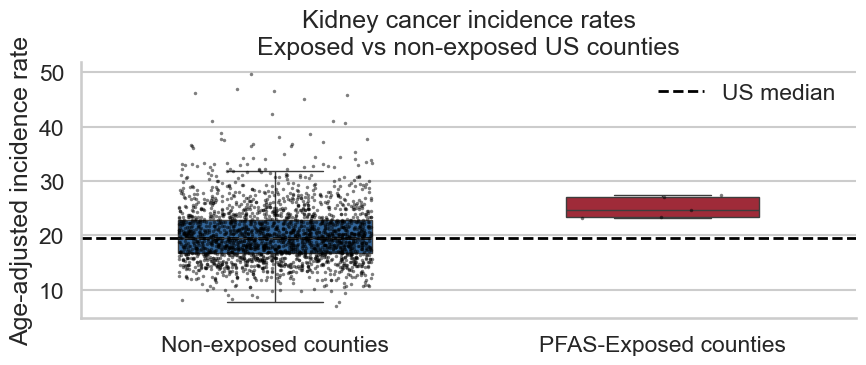

In [7]:
#creo un Boxplot dei tassi di incidenza (age adjusted)
#separati in base a exposizione nel dataset US_plot_df(Exposure)

#dimensione figura
plt.figure(figsize=(9,4))

sns.boxplot(
    data=US_plot_df,
    x="Exposure",
    y="Age_Adjusted_Rate",
    hue="Exposure",                  #colore box basato su categoria Exposure
    palette=["#2166ac", "#b2182b"],  #colori blu e rosso 
    width=0.5,                       #larghezza box
    showfliers=False,                #non mostra i punti outlier
    legend=False                     #no legenda 
)

#aggiungo i singoli puntini per visualizzare meglio la distribuzione delle singole contee
sns.stripplot(
    data=US_plot_df,
    x="Exposure",
    y="Age_Adjusted_Rate",
    color="black",          #colore punti
    alpha=0.5,              
    jitter=0.25,            #leggera dispersione orizzontale dei punti
    size=2.5                #dimensione punti
)

#linea orizzontale a rappresentazione della mediana
plt.axhline(
    national_median,
    linestyle="--",
    linewidth=2,
    color="black",
    label="US median"
)
#nomi assi
plt.ylabel("Age-adjusted incidence rate")
plt.xlabel("")
#titolo
plt.title("Kidney cancer incidence rates\nExposed vs non-exposed US counties")

plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()



##Posizionamento nel contesto nazionale
- Nel contesto della distribuzione complessiva delle contee statunitensi, quelle esposte si collocano nella parte superiore dell’intervallo dei tassi osservati.
- I valori osservati non risultano distribuiti casualmente rispetto alla baseline nazionale.

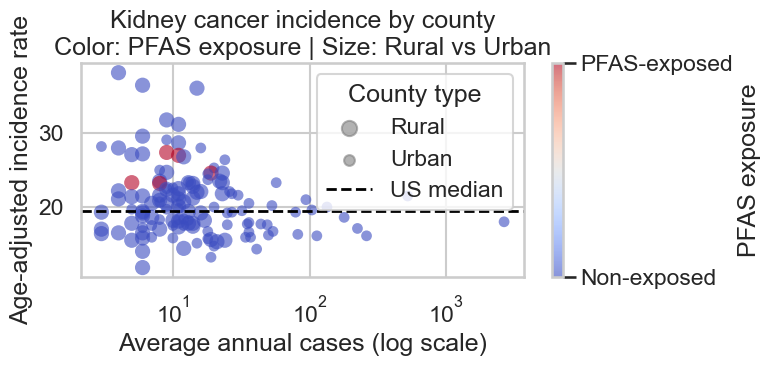

In [8]:





#dimensione figura
plt.figure(figsize=(8,4))

#scatter dei tassi di incidenza vs numero di  casi annuali

scatter = plt.scatter(
    plot_df["Annual_Cases"],          #asse x: numero annuale di casi per contea 
    plot_df["Age_Adjusted_Rate"],     #asse y: tasso incidenza
    c=plot_df["Exposed"],             #colore dei punti in base all'esposizione
    cmap="coolwarm",                  #mappa colori per la differenziazione dei gruppi
    s=np.where(plot_df["Rural/Urban"] == "Rural", 120, 60), 
                                      #dimensione punti in base alla contea: grande = rurale, piccoli=urbana
    alpha=0.6,
    linewidth=0                       #no bordo punti
)

#applico una scala logaritmica all'asse x per visualizzare meglio le differenze
plt.xscale("log")

#Aggiungo una linea per la mediana
plt.axhline(
    national_median,
    linestyle="--",
    color="black",
    linewidth=2,
    label="US median"   #etichetta della linea 
)

#etichette assi
plt.xlabel("Average annual cases (log scale)")
plt.ylabel("Age-adjusted incidence rate")
#titolo
plt.title("Kidney cancer incidence by county\nColor: PFAS exposure | Size: Rural vs Urban")

#Colorbar per indicare la legenda dei colori dei punti
cbar = plt.colorbar(scatter, ticks=[0,1])                  #colore dei punti mappati su 0 e 1
cbar.ax.set_yticklabels(["Non-exposed", "PFAS-exposed"])   #etichette leggibili
cbar.set_label("PFAS exposure")                            #titolo colorbar

#Creo una legenda personalizzata per dimensione dei punti e linea della mediana
plt.legend(handles=[
       #punto grande grigio per rappresentare contee rurali 
        plt.scatter([], [], s=120, color="gray", alpha=0.6, label="Rural"),
       #punto piccolo grigio per rappresentare contee urbane
        plt.scatter([], [], s=60, color="gray", alpha=0.6, label="Urban"),
       #Linea nera tratteggiata per la mediana
     Line2D([0], [0],
            color="black",
            linestyle="--",
            linewidth=2,
            label="US median")
    ],
    title="County type")                                  #titolo della legenda 

plt.tight_layout()
plt.show()








##Confronto contee esposte vs non esposte Ohio e West Virgina
- Le contee di riferimento presentano valori d'incidenza sistematicamente superiori alla mediana nazionale.
- Altre contee mostrano una distribuzione dei tassi più vicina al valore di riferimento nazionale.

In [9]:
#Leggo lo shapefile delle contee statunitensi utilizzando GeoPandas
#Questo crea un GeoDataFrame con geometrie poligonali delle contee
counties = gpd.read_file("data/Shapefile/tl_2022_us_county.shp")

# Converto la colonna "GEOID" in interi e la salvo come nuova colonna "Fips"
# GEOID è l'identificativo univoco della contea nel dataset geografico
# Creare "Fips" come intero facilita il merge con i DataFrame epidemiologici già indicizzati tramite FIPS
counties["Fips"] = counties["GEOID"].astype(int)


In [10]:
# Faccio il merge tra il GeoDataFrame delle contee e il DataFrame epidemiologico
# Utilizzo la colonna "Fips" come chiave comune
# 'how="left"' mantiene tutte le geometrie delle contee, aggiungendo i dati di df dove disponibili
gdf = counties.merge(
    df,
    on="Fips",
    how="left"
)

# Creo subset specifici per Ohio e West Virginia filtrando per lo stato
gdf_oh = gdf[gdf["State"] == "OH"]
gdf_wv = gdf[gdf["State"] == "WV"]

# Definisco una lista di colori per la mappa coropletica: blu = basso, giallo = moderato, rosso = alto
colors = ["#4575b4", "#fee08b", "#d73027"]  # blu / giallo / rosso

# Definisco i confini dei bin per classificare i tassi di incidenza
bins = [0, 18, 22, 100]  # soglie     low<18, Moderate 18-22, High>22

# Etichette corrispondenti ai bin
labels = ["Low", "Moderate", "High"]

# Creo una colormap personalizzata basata sui colori definiti
cmap = mcolors.ListedColormap(colors)

# Normalizzazione dei valori numerici per mappare correttamente i bin sui colori
# BoundaryNorm associa ciascun intervallo di 'bins' a un colore della colormap
norm = BoundaryNorm(bins, cmap.N)




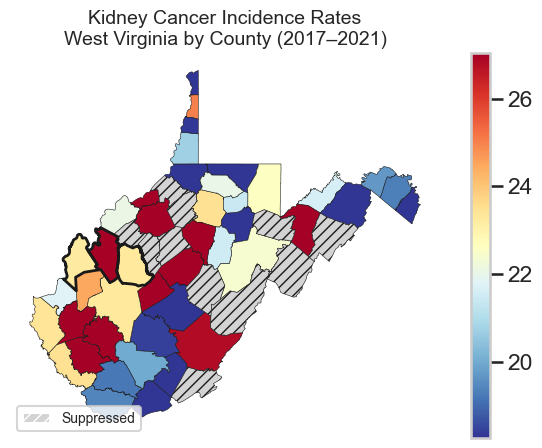

In [11]:
#creo figura e asse su cui disegnare la mappa

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Imposto una Normalizzazione dei colori più ristretta
vmin, vmax = gdf_wv["Age_Adjusted_Rate"].min(), gdf_wv["Age_Adjusted_Rate"].max()
# Limito la scala al 20°-80° percentile di modo da avere un'omogeneità nei colori 
lower, upper = gdf_wv["Age_Adjusted_Rate"].quantile(0.2), gdf_wv["Age_Adjusted_Rate"].quantile(0.8)
norm = mcolors.Normalize(vmin=lower, vmax=upper)

# Plot principale
gdf_wv.plot(
    column="Age_Adjusted_Rate",
    cmap="RdYlBu_r",              #colormap(blu=valori bassi, rosso=valori alti)
    linewidth=0.4,                #spessore bordi contee
    edgecolor="k",
    legend=True,                  #legenda
    ax=ax,                        #asse su cui disegnare la mappa
    norm=norm,                    #applica la scala ristretta
    missing_kwds={                #contee suppressed
        "color": "lightgrey",
        "hatch": "///"
    }
)

# Evidenzio le county esposte
gdf_exposed = gdf_wv[gdf_wv["Exposed"] == 1]
gdf_exposed.boundary.plot(
    ax=ax,
    color="k",
    linewidth=2
)

#legenda per le county "suppressed"
suppressed_patch = mpatches.Patch(facecolor="lightgrey", hatch="///", label="Suppressed")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles + [suppressed_patch], fontsize=10, loc="lower left")

ax.set_title(
    "Kidney Cancer Incidence Rates\nWest Virginia by County (2017–2021)",
    fontsize=14
)
ax.axis("off")       #nascondo asse
plt.show()

   

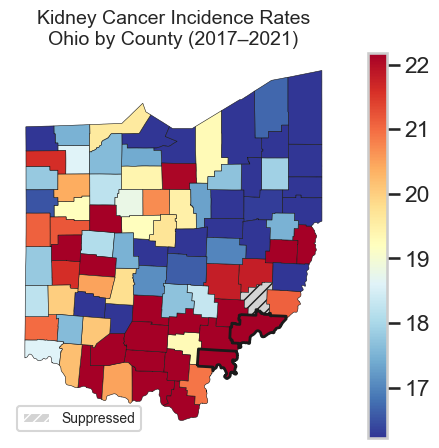

In [12]:
#

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

#Normalizzazione dei colori più ristretta
vmin, vmax = gdf_oh["Age_Adjusted_Rate"].min(), gdf_oh["Age_Adjusted_Rate"].max()
# Limito la scala al 20°-80° percentile
lower, upper = gdf_oh["Age_Adjusted_Rate"].quantile(0.2), gdf_oh["Age_Adjusted_Rate"].quantile(0.8)
norm = mcolors.Normalize(vmin=lower, vmax=upper)

# Plot principale
gdf_oh.plot(
    column="Age_Adjusted_Rate",
    cmap="RdYlBu_r",
    linewidth=0.4,
    edgecolor="k",
    legend=True,
    ax=ax,
    norm=norm,   # applica la scala ristretta
    missing_kwds={
        "color": "lightgrey",
        "hatch": "///"
    }
)

# Evidenzio le county esposte
gdf_exposed = gdf_oh[gdf_oh["Exposed"] == 1]
gdf_exposed.boundary.plot(
    ax=ax,
    color="k",
    linewidth=2
)

#legenda per le county "suppressed"
suppressed_patch = mpatches.Patch(facecolor="lightgrey", hatch="///", label="Suppressed")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles + [suppressed_patch], fontsize=10, loc="lower left")

ax.set_title(
    "Kidney Cancer Incidence Rates\nOhio by County (2017–2021)",
    fontsize=14
)
ax.axis("off")
plt.show()

   

##Analisi spaziale(Pattern geografico)
- Le contee con valori più elevati di incidenza risultano geograficamente concentrate lungo il corso del fiume Ohio, a valle dello stabilimento DuPont.

## Contesto geografico

Visualizzazione grafica fiume Ohio e dintorni
![Ohio River basin and surrounding states](ohio-river-map.jpg)

##Caratteristiche territoriali

-Le contee esposte sono prevalentemente classificate come aree rurali.

-In tali contesti, i tassi di incidenza potrebbero essere influenzati da popolazioni più ridotte e da una minore disponibilità di infrastrutture sanitarie.

##Limiti dello studio
##Considerazioni metodologiche
- L’analisi si basa su dati aggregati a livello di contea.
- Non è possibile stabilire relazioni causali a partire dai dati osservazionali utilizzati.
- Le stime nelle contee rurali possono essere soggette a maggiore variabilità.

##Conclusione
- L’analisi mostra che le contee storicamente esposte lungo il fiume Ohio presentano valori di incidenza del tumore renale sistematicamente superiori al riferimento nazionale.
- I risultati evidenziano differenze territoriali persistenti che meritano ulteriori approfondimenti epidemiologici.